In [1]:
import hdbscan
import pandas as pd
import numpy as np
%matplotlib ipympl
import matplotlib.pyplot as plt
from sklearn import manifold
from ipywidgets import interact, Output
from IPython.display import clear_output

import sys
sys.path.append('..')
from src.band_plotters import DATA_DIRECTORY
from src.cluster_plotters import plot_cluster_ellipses, plot_groups

In [2]:
FINGERPRINT_NAME = "all_k_branches_histogram_all_energies"
FINGERPRINT_LENGTH = 120
PERPLEXITY = 30
FLAT_ONLY = True
BORING_COLUMNS = ["segments", "flat_segments", "flatness_score", "binary_flatness", "horz_flat_seg", "exfoliation_eg", "band_gap", "A", "B", "C", "D", "E", "F"]
INPUT_NAME = f"{FINGERPRINT_NAME}_perplexity_{PERPLEXITY}_length_{FINGERPRINT_LENGTH}.csv"

## Load Data

In [3]:
df = pd.read_csv(f"../fingerprints/{INPUT_NAME}", index_col="ID")
if FLAT_ONLY:
    df = df[df.horz_flat_seg>0]
df.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,...,112,113,114,115,116,117,118,119,fx,fy
ID,,,,,,,,,,,,,,,,,,,,,
2dm-1,IrF2,AB2,164,3,0,0.095102,bottom-up,0,0,0.234620,...,33.0,36.0,37.0,55.0,21.0,14.0,8.0,12.0,-64.479750,41.871872
2dm-2,Ba2Sb,AB2,164,3,1,0.387410,bottom-up,0,0,0.210650,...,45.0,30.0,62.0,85.0,62.0,69.0,43.0,17.0,-105.356550,46.542330
2dm-3,TlS,AB,2,4,4,0.846460,bottom-up,1,3,0.095794,...,44.0,55.0,50.0,57.0,89.0,119.0,103.0,53.0,44.282880,48.410385
2dm-4,MoCl2,AB2,166,5,4,0.713760,bottom-up,0,0,-0.055818,...,55.0,44.0,114.0,33.0,97.0,106.0,178.0,201.0,7.897647,115.018936
2dm-6,RuI2,AB2,164,3,1,0.264930,bottom-up,0,0,0.084831,...,12.0,30.0,18.0,60.0,58.0,73.0,61.0,66.0,-103.296550,9.207986


## Cluster

In [4]:
fingerprint_cols = [str(i) for i in range(FINGERPRINT_LENGTH)]
BORING_COLUMNS += fingerprint_cols

In [5]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                        gen_min_span_tree=False, leaf_size=40, metric='minkowski', cluster_selection_method='leaf', min_cluster_size=4, min_samples=4, p=0.2)
clusterer.fit(df[fingerprint_cols])

df["labels"] = clusterer.labels_

interactive(children=(IntSlider(value=55, description='label', max=112, min=-1), Output()), _dom_classes=('wid…

<function __main__.view_cluster(label)>

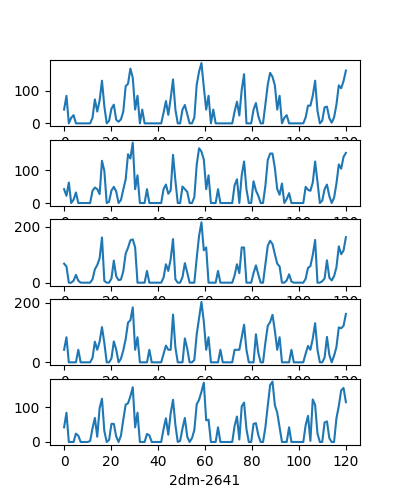

In [6]:
def view_cluster(label):
    display(df[df.labels==label].drop(BORING_COLUMNS, axis=1).head(100))

    num_plots = len(df[df.labels==label])

    fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

    for i, index in enumerate(df[df.labels==label].index):
        ax[i].plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols])
        ax[i].set_xlabel(index)
    
    
interact(view_cluster, label=(-1, len(np.unique(df.labels))-2, 1))

## Plots

Output()

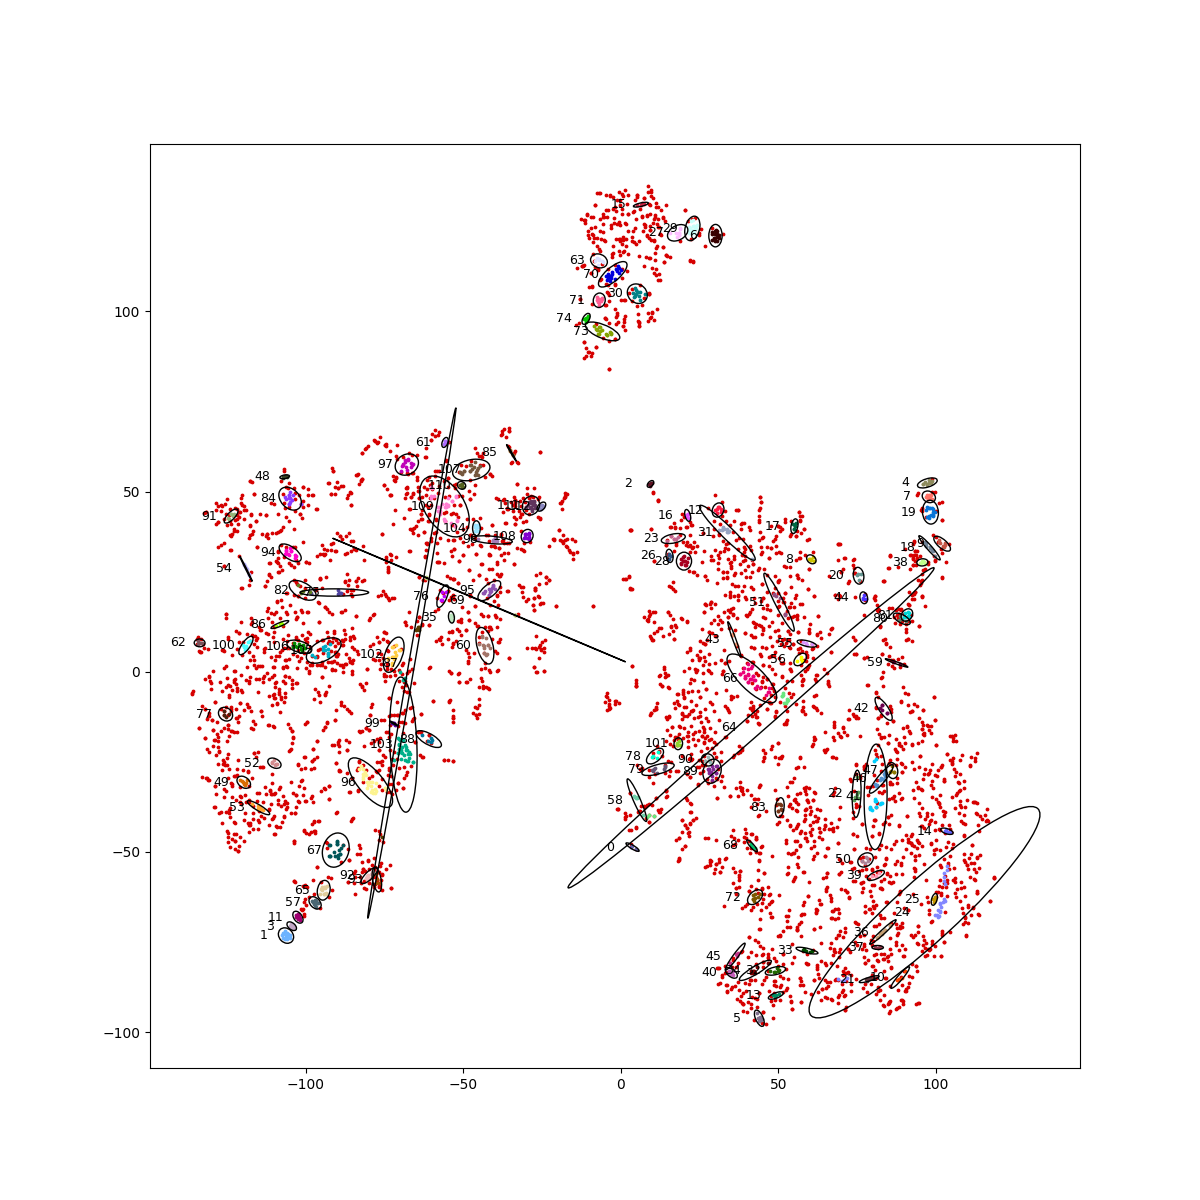

In [7]:
out = Output()

@out.capture()
def onclick(event):
    clear_output()
    closest = np.sqrt((event.xdata-df.fx)**2 + (event.ydata-df.fy)**2).idxmin()
    label = df.labels.loc[closest]
    print(f"Clicked on material {closest} in cluster {label}")
    display(df[df.labels == label].drop(BORING_COLUMNS, axis=1))
display(out)

fig, ax = plt.subplots(figsize=(12, 12))
ax = plot_groups(df,"labels", ax=ax)
ax = plot_cluster_ellipses(df, ax=ax, color="black")
# ax.legend()

fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()